
Fixing Automatic Classification of Wasan Kanji
---

In this notebook we are going to have a small application to read Kanji that were previously detected and classified and show the classification results. Users will then be asked to either confirm or refute (allowing for entering the right classification. 

In [1]:
# download github code

In [2]:
# general imports
from matplotlib import pyplot as plt
import os
import timeit
import cv2
import numpy as np
from pathlib import Path
import pandas as pd

import time


#local function imports
from imageUtils import read_Color_Image

In [3]:
# Integrate plots into notebook
#%matplotlib notebook
%matplotlib inline

# Preliminaries


## Download Data

First, we will donwload the data to make sure we have it in our colab machine or our local computer using either [the "requests" library](https://requests.readthedocs.io/en/latest/) or the wget linux command.

In [ ]:
import urllib.request

# Check if we are in colab or not and choose the best option for every case
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False


if IN_COLAB:
  !wget 'https://www.dropbox.com/scl/fi/gu9rfe7czbsxwipbkihbe/Data_Sarah.zip?rlkey=gc9wbbg5k189mi07pjjzvhkl4&st=nnizw49z&dl=0'
  !mv "Data_Sarah.zip?rlkey=gc9wbbg5k189mi07pjjzvhkl4&st=nnizw49z&dl=0" Data_Sarah.zip
else:
    url = 'https://www.dropbox.com/scl/fi/gu9rfe7czbsxwipbkihbe/Data_Sarah.zip?rlkey=gc9wbbg5k189mi07pjjzvhkl4&st=nnizw49z&dl=0'
    filename = 'Data_Sarah.zip'
    urllib.request.urlretrieve(url, filename)

!unzip Data_Sarah.zip


## Explain what we will see

In [3]:
# variables
dataFolder = "./OU"
annotationFile ="./kanjiPredictions.txt"

In [ ]:
# Set up google sheet
from google.colab import auth
#auth.authenticate_user()
from google.auth import default
creds, _ = default()

import gspread
# gspread examples and documentation: https://github.com/burnash/gspread

gc = gspread.authorize(creds)

# This is the spreadsheet we are using as an example
# https://docs.google.com/spreadsheets/d/1NBFsCp0rw87u5S-GS2TiPMvpDLzTC3SrbrlLJcO0M6E
sh = gc.open_by_key('1O3rUEvVyN8iIRxV_iTG1E2INpEuPZKArVvUUJYrRYvQ')


worksheet = sh.get_worksheet(0)

print(worksheet.get_all_records())
print('User modifying the file:', gc.auth.service_account_email)

## Load annotations

In [4]:
data = pd.read_csv(annotationFile)

In [5]:
numPreds = len(data.columns)-1
data

,imageName,Pred1,Pred2,Pred3,Pred4,Pred5
0,sakuma-0001_Pаgina_04_Imagen_0001kanjiX2128Y19...,湯,満,論,輪,賎
1,sakuma-0001_Pаgina_04_Imagen_0001kanjiX846Y154...,浅,殘,儀,賊,城
2,sakuma-0001_Pаgina_04_Imagen_0001kanjiX1418Y30...,酒,物,風,國,曲
3,sakuma-0001_Pаgina_04_Imagen_0001kanjiX2208Y23...,同,日,而,前,雨
4,sakuma-0001_Pаgina_04_Imagen_0001kanjiX1038Y22...,口,也,候,六,此
...,...,...,...,...,...,...
154,sakuma-0001_Pаgina_04_Imagen_0001kanjiX1115Y11...,暇,賊,助,物,納
155,sakuma-0001_Pаgina_04_Imagen_0001kanjiX948Y850...,候,日,同,門,川
156,sakuma-0001_Pаgina_04_Imagen_0001kanjiX2122Y18...,同,酒,候,成,口
157,sakuma-0001_Pаgina_04_Imagen_0001kanjiX1126Y25...,湯,酒,風,頃,帰


# Add a column to the DataFrame to store the annotations

In [20]:
# create new column with empty values
data['Expert'] = pd.Series(dtype='string')
data['Expert'] = ""
data

,imageName,Pred1,Pred2,Pred3,Pred4,Pred5,Expert
0,sakuma-0001_Pаgina_04_Imagen_0001kanjiX2128Y19...,湯,満,論,輪,賎,
1,sakuma-0001_Pаgina_04_Imagen_0001kanjiX846Y154...,浅,殘,儀,賊,城,
2,sakuma-0001_Pаgina_04_Imagen_0001kanjiX1418Y30...,酒,物,風,國,曲,
3,sakuma-0001_Pаgina_04_Imagen_0001kanjiX2208Y23...,同,日,而,前,雨,
4,sakuma-0001_Pаgina_04_Imagen_0001kanjiX1038Y22...,口,也,候,六,此,
...,...,...,...,...,...,...,...
154,sakuma-0001_Pаgina_04_Imagen_0001kanjiX1115Y11...,暇,賊,助,物,納,
155,sakuma-0001_Pаgina_04_Imagen_0001kanjiX948Y850...,候,日,同,門,川,
156,sakuma-0001_Pаgina_04_Imagen_0001kanjiX2122Y18...,同,酒,候,成,口,
157,sakuma-0001_Pаgina_04_Imagen_0001kanjiX1126Y25...,湯,酒,風,頃,帰,


# Loop to modify the annotations 

In [35]:
def stringFromPreds(info):
    """
    Create a string to print
    from predictions
    """
    print("received"+str(info))
    retS = ""
    for i in range(1,len(info)-1):
        retS+=str(i)+": "+info[i]+" "
    print("returning"+str(retS))
    return retS

0
['sakuma-0001_Pаgina_04_Imagen_0001kanjiX2128Y1980H101W116.jpg', '湯', '満', '論', '輪', '賎', '湯']


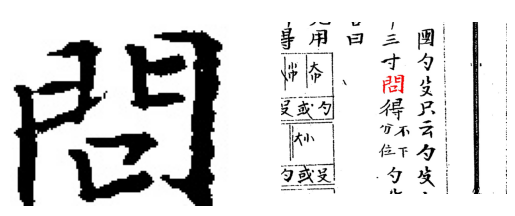

received['sakuma-0001_Pаgina_04_Imagen_0001kanjiX2128Y1980H101W116.jpg', '湯', '満', '論', '輪', '賎', '湯']
returning1: 湯 2: 満 3: 論 4: 輪 5: 賎 
1: 湯 2: 満 3: 論 4: 輪 5: 賎 
 Press a number to choose, or type your kanji, "b" to finish, 0 if you don't know1
 Choose option 1 : 湯
1
['sakuma-0001_Pаgina_04_Imagen_0001kanjiX846Y1540H112W81.jpg', '浅', '殘', '儀', '賊', '城', '城']


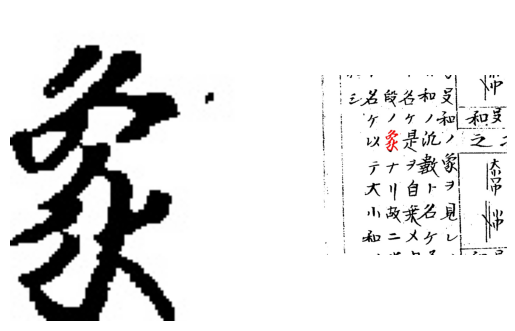

received['sakuma-0001_Pаgina_04_Imagen_0001kanjiX846Y1540H112W81.jpg', '浅', '殘', '儀', '賊', '城', '城']
returning1: 浅 2: 殘 3: 儀 4: 賊 5: 城 
1: 浅 2: 殘 3: 儀 4: 賊 5: 城 
 Press a number to choose, or type your kanji, "b" to finish, 0 if you don't know1
 Choose option 1 : 浅
2
['sakuma-0001_Pаgina_04_Imagen_0001kanjiX1418Y3012H101W106.jpg', '酒', '物', '風', '國', '曲', '酒']


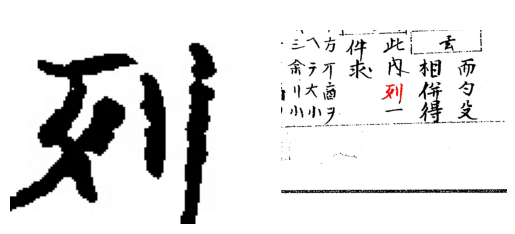

received['sakuma-0001_Pаgina_04_Imagen_0001kanjiX1418Y3012H101W106.jpg', '酒', '物', '風', '國', '曲', '酒']
returning1: 酒 2: 物 3: 風 4: 國 5: 曲 
1: 酒 2: 物 3: 風 4: 國 5: 曲 
 Press a number to choose, or type your kanji, "b" to finish, 0 if you don't know川
added new Kanji 川
3
['sakuma-0001_Pаgina_04_Imagen_0001kanjiX2208Y2324H72W60.jpg', '同', '日', '而', '前', '雨', '同']


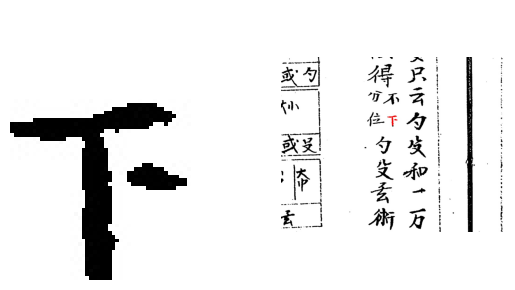

received['sakuma-0001_Pаgina_04_Imagen_0001kanjiX2208Y2324H72W60.jpg', '同', '日', '而', '前', '雨', '同']
returning1: 同 2: 日 3: 而 4: 前 5: 雨 
1: 同 2: 日 3: 而 4: 前 5: 雨 
 Press a number to choose, or type your kanji, "b" to finish, 0 if you don't know0
UNKNOWN
4
['sakuma-0001_Pаgina_04_Imagen_0001kanjiX1038Y2236H82W68.jpg', '口', '也', '候', '六', '此', '口']


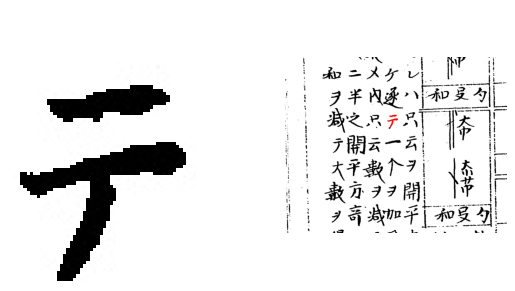

received['sakuma-0001_Pаgina_04_Imagen_0001kanjiX1038Y2236H82W68.jpg', '口', '也', '候', '六', '此', '口']
returning1: 口 2: 也 3: 候 4: 六 5: 此 
1: 口 2: 也 3: 候 4: 六 5: 此 
 Press a number to choose, or type your kanji, "b" to finish, 0 if you don't know1
 Choose option 1 : 口
5
['sakuma-0001_Pаgina_04_Imagen_0001kanjiX1346Y1312H77W86.jpg', '候', '同', '日', '口', '弐', '口']


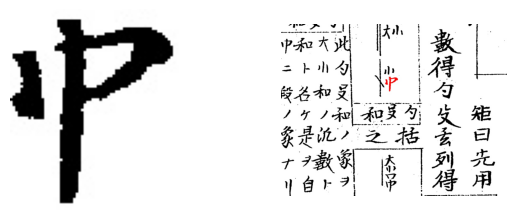

received['sakuma-0001_Pаgina_04_Imagen_0001kanjiX1346Y1312H77W86.jpg', '候', '同', '日', '口', '弐', '口']
returning1: 候 2: 同 3: 日 4: 口 5: 弐 
1: 候 2: 同 3: 日 4: 口 5: 弐 
 Press a number to choose, or type your kanji, "b" to finish, 0 if you don't know筍大
Wrong information entered, moving on without modification
6
['sakuma-0001_Pаgina_04_Imagen_0001kanjiX1567Y1207H113W128.jpg', '湯', '論', '盛', '帰', '酒', '湯']


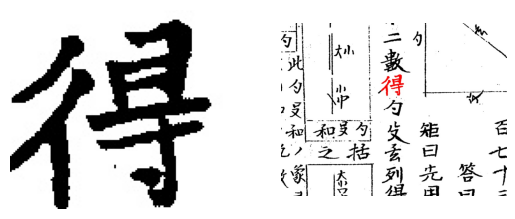

received['sakuma-0001_Pаgina_04_Imagen_0001kanjiX1567Y1207H113W128.jpg', '湯', '論', '盛', '帰', '酒', '湯']
returning1: 湯 2: 論 3: 盛 4: 帰 5: 酒 
1: 湯 2: 論 3: 盛 4: 帰 5: 酒 
 Press a number to choose, or type your kanji, "b" to finish, 0 if you don't knowb
BREAK!


In [40]:
# modify iteration variables if necessary
firstPos = 0
lastPos = 158

#pos
for i in data.index:
    row = data.loc[i, :].values.tolist()
    print(i)
    print(row)
    # read image
    im = read_Color_Image(os.path.join(dataFolder,row[0]))
    imContext = read_Color_Image(os.path.join(dataFolder,"CONTEXT"+row[0]))[:,:,::-1]
    
    f, axarr = plt.subplots(1,2)

    # now show patches for an id
    axarr[0].imshow(im)
    axarr[0].axis('off')
    axarr[1].imshow(imContext)
    axarr[1].axis('off')
    #plt.subplots_adjust(wspace=0.2, hspace=-0.6)
    plt.show()
    time.sleep(0.5)
    key = input(stringFromPreds(row[0:])+"\n Press a number to choose, or type your kanji, \"b\" to finish, 0 if you don't know")
    try:
        val = int(key)
        if 0 < val <= numPreds:
            print(" Choose option "+key+" : "+row[val])
            data.at[i,"Expert"] = row[val]
        elif 0 == val:
            print("UNKNOWN")
            data.at[i,"Expert"] = "?"
        else:
            print("Wrong number entered, moving on without modification")
    except:
        if key == "b":
            print("BREAK!")
            break
        else:
            if len(key)>1:
                print("Wrong information entered, moving on without modification")
            else:
                print("added new Kanji "+str(key))
                data.at[i,"Expert"] = str(key)

In [42]:
data.head(10)

,imageName,Pred1,Pred2,Pred3,Pred4,Pred5,Expert
0,sakuma-0001_Pаgina_04_Imagen_0001kanjiX2128Y19...,湯,満,論,輪,賎,湯
1,sakuma-0001_Pаgina_04_Imagen_0001kanjiX846Y154...,浅,殘,儀,賊,城,浅
2,sakuma-0001_Pаgina_04_Imagen_0001kanjiX1418Y30...,酒,物,風,國,曲,川
3,sakuma-0001_Pаgina_04_Imagen_0001kanjiX2208Y23...,同,日,而,前,雨,?
4,sakuma-0001_Pаgina_04_Imagen_0001kanjiX1038Y22...,口,也,候,六,此,口
5,sakuma-0001_Pаgina_04_Imagen_0001kanjiX1346Y13...,候,同,日,口,弐,口
6,sakuma-0001_Pаgina_04_Imagen_0001kanjiX1567Y12...,湯,論,盛,帰,酒,湯
7,sakuma-0001_Pаgina_04_Imagen_0001kanjiX1575Y78...,入,次,候,人,頃,
8,sakuma-0001_Pаgina_04_Imagen_0001kanjiX935Y244...,賊,編,碗,満,盛,
9,sakuma-0001_Pаgina_04_Imagen_0001kanjiX1034Y23...,二,三,一,上,之,


# Save the results to a spreadsheet


In [43]:
from google.colab import auth
auth.authenticate_user()

import gspread
# gspread examples and documentation: https://github.com/burnash/gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# This is the spreadsheet we are using as an example
# https://docs.google.com/spreadsheets/d/1NBFsCp0rw87u5S-GS2TiPMvpDLzTC3SrbrlLJcO0M6E
sh = gc.open_by_key('1NBFsCp0rw87u5S-GS2TiPMvpDLzTC3SrbrlLJcO0M6E')

worksheet = sh.get_worksheet(0)

print(worksheet.get_all_records())
print('User modifying the file:', gc.auth.service_account_email)

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
worksheet.update("A1:C1", [["hesllo","jjj","jlk"]])

In [ ]:
# populate spreadsheed with data from the dataframe


aDict = dict19
worksheet.update("A1:E1", [["Year","id","px","py","category"]])

for k,v in aDict.items():
    # Update a range of cells using the top left corner address
    rangeNow = "A"+str(k+1)+":"+"E"+str(k+1)
    worksheet.update(rangeNow, [["2019",int(k),int(v[0]),int(v[1]),v[2]]])

#https://docs.gspread.org/en/latest/user-guide.html#using-gspread-with-pandas
#https://stackoverflow.com/questions/62917910/how-can-i-export-pandas-dataframe-to-google-sheets-using-python
